In [1]:
# playground for GNN data processing

import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch as th
from matplotlib import pyplot as plt

import os

In [2]:
# extract filenames from npy_GNN folder

def get_filenames(directory):
    filenames = []
    for file in os.listdir(f"../npy_GNN/{directory}"):
        if file[-4:] == ".npy":
            filenames.append(file)
    filenames.sort()
    return filenames

names = get_filenames("2024-05-15_11:57:51_dynamic")
print(names)

# create a second list with the same filenames but without everything after the first underscore

def get_filenames_no_time(directory):
    filenames = []
    for file in os.listdir(f"../npy_GNN/{directory}"):
        if file[-4:] == ".npy":
            filenames.append(file)
    filenames.sort()
    for i in range(len(filenames)):
        filenames[i] = filenames[i].split("_")[0] + ".npy"
    return filenames

names_no_time = get_filenames_no_time("2024-05-15_11:57:51_dynamic")
types = len(set(names_no_time))

samples = len(names) // types
print(types, samples)

['CoarseResPoints_10.789_x_-0.283_y_0.959.npy', 'CoarseResPoints_11.324_x_-0.578_y_0.816.npy', 'CoarseResPoints_11.577_x_-0.049_y_0.999.npy', 'CoarseResPoints_12.313_x_0.79_y_-0.614.npy', 'CoarseResPoints_13.037_x_0.269_y_0.963.npy', 'CoarseResPoints_13.537_x_0.798_y_0.603.npy', 'CoarseResPoints_13.746_x_-0.944_y_0.33.npy', 'CoarseResPoints_14.492_x_1.0_y_0.026.npy', 'CoarseResPoints_15.447_x_-0.979_y_0.202.npy', 'CoarseResPoints_15.796_x_0.671_y_-0.741.npy', 'CoarseResPoints_15.811_x_0.434_y_0.901.npy', 'CoarseResPoints_16.065_x_-0.327_y_-0.945.npy', 'CoarseResPoints_16.365_x_-0.777_y_0.629.npy', 'CoarseResPoints_16.95_x_-0.085_y_-0.996.npy', 'CoarseResPoints_17.222_x_-0.673_y_0.74.npy', 'CoarseResPoints_17.284_x_-0.365_y_-0.931.npy', 'CoarseResPoints_17.359_x_-0.877_y_0.48.npy', 'CoarseResPoints_17.643_x_1.0_y_0.005.npy', 'CoarseResPoints_19.718_x_0.161_y_0.987.npy', 'CoarseResPoints_20.173_x_-0.817_y_0.577.npy', 'CoarseResPoints_21.045_x_0.53_y_-0.848.npy', 'CoarseResPoints_22.494_x

In [3]:

# create a function to transform the data into a list of Data objects

from torch import le


def extract_identifier(filename):
    # extract the identifier from the filename
    return int(filename.split('_')[-1].replace('.npy', ''))

def create_data_list(directory):
    names_unsorted = get_filenames(directory)
    
    names = sorted(names_unsorted, key=lambda x: (extract_identifier(x), x))
    samples = len(names) // 6
    data_list = []
    for i in range(samples - 1):
        low_res_displacement = np.load(f"../npy_GNN/{directory}/{names[i*6]}")
        high_res_displacement = np.load(f"../npy_GNN/{directory}/{names[i*6+3]}")
        high_res_velocity = np.load(f"../npy_GNN/{directory}/{names[i*6+4]}")
        low_res_velocity = np.load(f"../npy_GNN/{directory}/{names[i*6+5]}")
        node_features = np.hstack((low_res_displacement, high_res_displacement, low_res_velocity, high_res_velocity))
        edge_index = np.load(f"../npy_GNN/{directory}/{names[i*6+2]}")[:, :2].T
        edge_attr = np.load(f"../npy_GNN/{directory}/{names[i*6+2]}")[:, 2]
        y = high_res_displacement - low_res_displacement
        data = Data(x=th.tensor(node_features, dtype=th.float32), edge_index=th.tensor(edge_index, dtype=th.long), edge_attr=th.tensor(edge_attr, dtype=th.float32), y=th.tensor(y, dtype=th.float32))
        data_list.append(node_features)
    return data_list






In [4]:
data_list = create_data_list("2024-08-07_17:40:37_dynamic")

print(data_list[0].shape)
val_data_list = create_data_list("2024-08-08_14:35:35_dynamic")


(75, 12)


In [5]:
print(len(data_list), len(val_data_list))

56799 3999


In [6]:


data = np.empty((len(data_list)//100, 4, 100))
val_data = np.empty((len(val_data_list)//100, 4, 100))

counter = 0
samples = 0
for i in range(data.shape[0]):
    samples += 1
    for time in range(100):

        data[i, 0, time] = data_list[i*100+time][44, 1] #low_res_displacement
        data[i, 1, time] = data_list[i*100+time][44, 4] #high_res_displacement 
        data[i, 2, time] = data_list[i*100+time][44, 7] #low_res_velocity
        data[i, 3, time] = data_list[i*100+time][44, 10] #high_res_velocity

        if time == 99:
            abs_val = np.abs(data[i, 1, :])
            peak = np.argmax(abs_val)
            if (not np.all(abs_val[peak+1:] < abs_val[peak])) or (peak > 10 and abs_val[peak] > 0.05):
                print(f"Found a bad sample at {i}")
                # plt.plot(abs_val)
                # plt.plot(abs_val)
                # plt.plot(peak, abs_val[peak], 'ro')
                # plt.show()
                data[i, :, :] = -1
                counter += 1

print(f"Fount {counter} bad samples in the training data, the percentage is {counter/samples*100}%")
        
    
counter = 0
samples = 0
for i in range(val_data.shape[0]):
    samples += 1
    for time in range(100):
        val_data[i, 0, time] = val_data_list[i*100+time][44, 1]
        val_data[i, 1, time] = val_data_list[i*100+time][44, 4]
        val_data[i, 2, time] = val_data_list[i*100+time][44, 7]
        val_data[i, 3, time] = val_data_list[i*100+time][44, 10]
    if time == 99:
        abs_val = np.abs(val_data[i, 1, :])
        peak = np.argmax(abs_val)
        if (not np.all(abs_val[peak+1:] < abs_val[peak])) or (peak > 10 and abs_val[peak] > 0.05):
            print(f"Found a bad sample at {i}")
            plt.plot(abs_val)
            plt.plot(abs_val)
            plt.plot(peak, abs_val[peak], 'ro')
            plt.show()
            val_data[i, :, :] = -1
            counter += 1

print(f"Fount {counter} bad samples in the validation data, the percentage is {counter/samples*100}%")
        




Found a bad sample at 13
Found a bad sample at 28
Found a bad sample at 88
Found a bad sample at 89
Found a bad sample at 118
Found a bad sample at 119
Found a bad sample at 163
Found a bad sample at 179
Found a bad sample at 194
Found a bad sample at 208
Found a bad sample at 238
Found a bad sample at 239
Found a bad sample at 269
Found a bad sample at 329
Found a bad sample at 358
Found a bad sample at 388
Found a bad sample at 418
Found a bad sample at 448
Found a bad sample at 478
Found a bad sample at 508
Found a bad sample at 538
Found a bad sample at 539
Fount 22 bad samples in the training data, the percentage is 3.880070546737213%
Fount 0 bad samples in the validation data, the percentage is 0.0%


In [7]:
print(data.shape, val_data.shape)
indexes = []
for i in range(len(val_data)):
    
    if np.all(val_data[i] == -1):
        
        indexes.append(i)
if len(indexes) > 0:
    val_data = np.delete(val_data, indexes, axis=0)
print(data.shape, val_data.shape)
indexes = []
for i in range(len(data)):
    
    if np.all(data[i] == -1):
        print(i)
        indexes.append(i)

if len(indexes) > 0:
    data = np.delete(data, indexes, axis=0)
print(data.shape, val_data.shape)



(567, 4, 100) (39, 4, 100)
(567, 4, 100) (39, 4, 100)
13
28
88
89
118
119
163
179
194
208
238
239
269
329
358
388
418
448
478
508
538
539
(545, 4, 100) (39, 4, 100)


In [8]:
#statistics
print(data.shape)
print(val_data.shape)

print(f"Max displacement: {np.max(data[:, 1, :])}")
print(f"Min displacement: {np.min(data[:, 1, :])}")
print(f"Max velocity: {np.max(data[:, 3, :])}")
print(f"Min velocity: {np.min(data[:, 3, :])}")
print("Negative values:")
print("validation")
print(f"Max displacement: {np.max(val_data[:, 1, :])}")
print(f"Min displacement: {np.min(val_data[:, 1, :])}")
print(f"Max velocity: {np.max(val_data[:, 3, :])}")
print(f"Min velocity: {np.min(val_data[:, 3, :])}")



(545, 4, 100)
(39, 4, 100)
Max displacement: 6.32422858367161
Min displacement: -6.340821435427643
Max velocity: 26.287382124639333
Min velocity: -26.176387434769435
Negative values:
validation
Max displacement: 5.021181021858023
Min displacement: -5.648614641159301
Max velocity: 20.85670504115791
Min velocity: -23.05519926876246


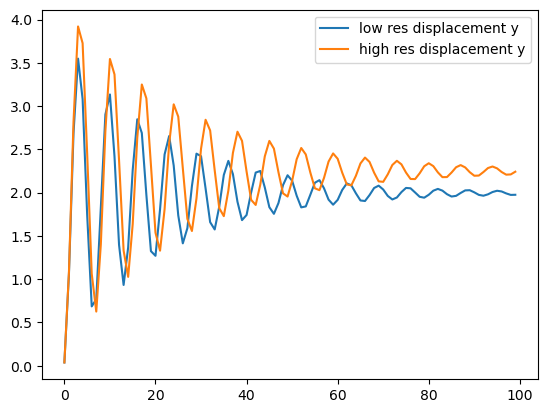

In [9]:

import matplotlib.pyplot as plt

plt.plot(val_data[10, 0, :], label="low res displacement y")
plt.plot(val_data[10, 1, :], label="high res displacement y")
plt.legend()
plt.show()
# plt.plot(data[0, 2, :], label="low res velocity y")
# plt.plot(data[0, 3, :], label="high res velocity y")

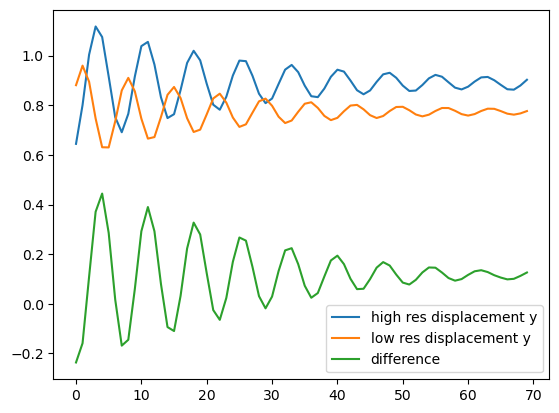

In [17]:
#plot of the velocity

plt.plot(data[10, 1, 30:], label="high res displacement y")
plt.plot(data[10, 0, 30:], label="low res displacement y")
plt.plot(data[10, 1, 30:]-data[10, 0, 30:], label="difference")
plt.legend()
plt.show()

epoch: 0, loss: 0.2235030366314782
validation loss: 0.1957165002822876
epoch: 1, loss: 0.1926820394065645
validation loss: 0.18092137575149536
epoch: 2, loss: 0.17948987086613974
validation loss: 0.16791269183158875
epoch: 3, loss: 0.16843038300673166
validation loss: 0.15391920506954193
epoch: 4, loss: 0.15670395394166312
validation loss: 0.14989855885505676
epoch: 5, loss: 0.15538200404908922
validation loss: 0.1489359587430954
epoch: 6, loss: 0.1552758796347512
validation loss: 0.14751259982585907
epoch: 7, loss: 0.15557083156373766
validation loss: 0.14726412296295166
epoch: 8, loss: 0.15240735312302908
validation loss: 0.1464090198278427
epoch: 9, loss: 0.15319724712106916
Counter: 1
Diff: 9.711086750030518e-05
validation loss: 0.14650613069534302
epoch: 10, loss: 0.1530485517448849
Counter: 2
Diff: 0.0009497255086898804
validation loss: 0.1473587453365326
epoch: 11, loss: 0.15405358374118805
Counter: 3
Diff: 0.0004955083131790161
validation loss: 0.14690452814102173
epoch: 12, lo

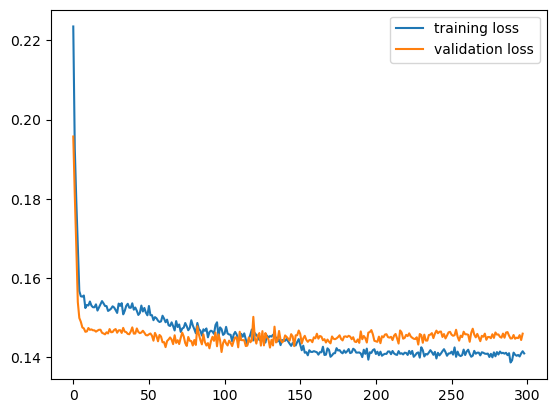

In [69]:
    
from gettext import find
import torch.nn.functional as F
from scipy.signal import find_peaks

class Net(th.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = th.nn.Linear(3, 8)
        self.linear2 = th.nn.Linear(8, 16)
        self.batchnorm = th.nn.BatchNorm1d(55)
        self.linear3 = th.nn.Linear(16, 32)
        self.dropout = th.nn.Dropout(0.25)
        self.linear4 = th.nn.Linear(32, 1)

    def forward(self, x):
        x = th.sin(self.linear1(x))
        x = th.sin(self.linear2(x))
        x = self.batchnorm(x)
        x = th.sin(self.linear3(x))
        x = self.dropout(x)
        x = self.linear4(x)

        return x
    
class Net2(th.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.linear1 = th.nn.Linear(3, 4)
        self.linear2 = th.nn.Linear(4, 16)
        self.batchnorm = th.nn.BatchNorm1d(55)
        self.linear3 = th.nn.Linear(16, 32)
        self.dropout = th.nn.Dropout(0.5)
        self.linear4 = th.nn.Linear(32, 1)

    def forward(self, x):
        #leaky relu activation function
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.linear2(x))
        x = self.batchnorm(x)
        x = F.leaky_relu(self.linear3(x))
        x = self.dropout(x)
        x = self.linear4(x)

        return x
    
class EnsembleNet(th.nn.Module):
    def __init__(self):
        super(EnsembleNet, self).__init__()
        self.net1 = Net()
        self.net2 = Net2()

    def forward(self, x):
        x1 = self.net1(x)
        x2 = self.net2(x)
        return (x1 + x2) / 2

    
class RMSELoss(th.nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = th.nn.MSELoss()
    
    def forward(self, yhat, y):
        return th.sqrt(self.mse(yhat, y))
    
class MixedLoss(th.nn.Module):
    # Custom loss function that computes the weighted sum between the root mean squared error and the maximum absolute error
    def __init__(self):
        super(MixedLoss, self).__init__()

    def forward(self, pred, true):
        # loss that computes the root mean squared error of the prediction and the true value and also the root mean squared error of the derivative of the prediction and the true value
        # peaks = th.tensor(find_peaks(true.cpu().detach().numpy())[0])
        # print(peaks)
        #return 0.5*th.sqrt(th.mean((pred[~peaks] - true[~peaks])**2)) + 0.5*th.mean(th.abs(pred[peaks] - true[peaks]))
     
        return th.sqrt(th.mean((pred - true)**2)) #+ 0.5*th.mean(th.abs(pred - true))

class Dataset(th.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.length = len(data)
        self.y_displacement = self.data[:, 1, 40:95]
        # self.y_displacement = (self.y_displacement - np.min(self.y_displacement)) / (np.max(self.y_displacement) - np.min(self.y_displacement))
        self.y_velocity = self.data[:, 3, 40:95]
        # self.y_velocity = (self.y_velocity - np.min(self.y_velocity)) / (np.max(self.y_velocity) - np.min(self.y_velocity))
        self.timestep = np.arange(55)
        #create a list of tuples with the y displacement and the timestep
        self.inputs = np.empty((self.length, 55, 3), dtype=np.float32)
        self.outputs = np.empty((self.length, 55, 1), dtype=np.float32)
        for i in range(self.inputs.shape[0]):
            self.inputs[i, :, 0] = self.y_displacement[i]
            self.inputs[i, :, 1] = self.timestep[i%55]
            self.inputs[i, :, 2] = self.y_velocity[i]
            self.outputs[i, :, 0] = self.data[i, 1, 45:] - self.data[i, 1, 40:95]
            #self.outputs[i, :, 1] = self.data[i, 3, :] - self.data[i, 2, :]
       

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]
    
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, lr = 0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.lr = lr

    def early_stop(self, validation_loss, learning_rate):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif learning_rate != self.lr:
            self.lr = learning_rate
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f"Counter: {self.counter}")
            print(f"Diff: {validation_loss - self.min_validation_loss}")
            if self.counter >= self.patience:
                return True
        return False
    
dataset = Dataset(data)
dataloader = th.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
val_dataset = Dataset(val_data)
val_dataloader = th.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

device = th.device('cuda' if th.cuda.is_available() else 'cpu')
model = EnsembleNet().to(device)
optimizer = th.optim.Adam(model.parameters(), lr=0.005)
criterion = MixedLoss()
model.train()
losses = []
val_losses = []
early_stopper = EarlyStopper(patience=200, min_delta=1e-7, lr=0.001)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50, min_lr=1e-8)
for epoch in range(10000):
    running_loss = 0.0
    for i, batch in enumerate(dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    print(f"epoch: {epoch}, loss: {running_loss / len(dataloader)}")
    losses.append(running_loss / len(dataloader))
    val_loss = 0.0
    for i, batch in enumerate(val_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        #outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        val_loss += loss.item()
    if early_stopper.early_stop(val_loss / len(val_dataloader), 0.001):
        print("Early stopping")
        break
    scheduler.step(val_loss / len(val_dataloader))
    

    print(f"validation loss: {val_loss / len(val_dataloader)}")
    val_losses.append(val_loss / len(val_dataloader))





#plot the losses
plt.plot(losses, label="training loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.show()




torch.Size([545, 55, 3])
(545, 55, 1)
(545, 55, 1)
(545, 4, 100)


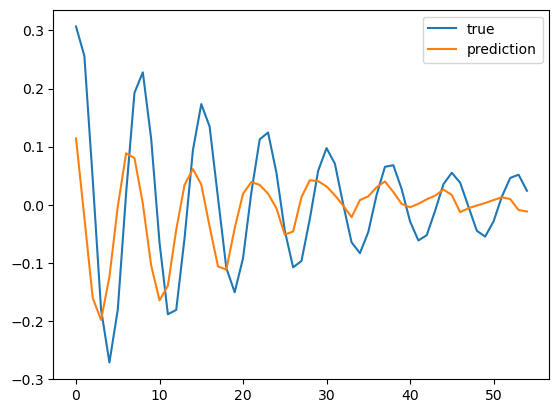

In [70]:
model.eval()
with th.no_grad():
    inputs = th.tensor(dataset.inputs, dtype=th.float32).to(device)
    print(inputs.shape)
    predictions = model(inputs).cpu().numpy()
    print(predictions.shape)

print(predictions.shape)
print(data.shape)
i = 45
plt.figure()
plt.plot(data[i, 1, 45:] - data[i, 1, 40:95], label="true")
plt.plot(predictions[i, :, 0], label="prediction")
plt.legend()
plt.show()

(39, 55, 1)
[ 2.16591462e-01  1.00803494e-01 -1.84959576e-01 -3.36544305e-01
 -3.34957659e-01 -2.07516015e-01 -2.32718885e-04  9.97858495e-02
  2.08671801e-02 -1.81888282e-01 -2.86156893e-01 -2.82015443e-01
 -1.64563194e-01 -2.39606947e-02  4.53709848e-02 -1.94746032e-02
 -1.57060266e-01 -2.46117115e-01 -2.43337184e-01 -1.32882327e-01
 -1.54935308e-02  2.94027478e-02 -4.45472151e-02 -1.29453346e-01
 -1.57768875e-01 -1.83139294e-01 -1.23536751e-01 -3.82209457e-02
  7.25024194e-03 -3.97127569e-02 -1.27088904e-01 -9.84769836e-02
 -1.00670278e-01 -9.74326134e-02 -3.00269425e-02  3.41656804e-03
 -1.72426999e-02 -9.38072801e-02 -8.55276212e-02 -5.69450855e-02
 -3.92716303e-02 -1.20541602e-02 -2.54452229e-04 -1.38954967e-02
 -5.53941056e-02 -6.68087900e-02 -1.57644935e-02 -2.17182860e-02
 -8.24017078e-03 -4.12441790e-03 -1.53612643e-02 -3.58089842e-02
 -4.50727977e-02 -9.94630530e-03 -1.32009387e-03]
(39, 4, 100)


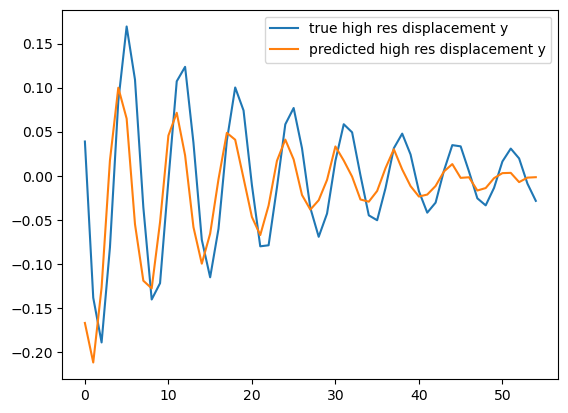

[0.03748724 1.06044886 2.68352811 3.54857505 3.08165634 1.74399434
 0.68537348 0.76798275 1.82785618 2.90296731 3.13409937 2.4186967
 1.39680941 0.93323272 1.36699329 2.26235718 2.84786062 2.68907405
 1.9738381  1.32389149 1.26987925 1.80632799 2.44125661 2.65385786
 2.31297502 1.7367069  1.4139737  1.58938464 2.076124   2.45026986
 2.4217155  2.04779337 1.65894375 1.57445614 1.83801801 2.20390754
 2.36684035 2.21388138 1.89464651 1.68227858 1.74157996 2.00084373
 2.23172661 2.25021516 2.05969818 1.83169207 1.75513846 1.87977432
 2.08668034 2.20079328 2.13811323 1.96428979 1.82971121 1.84072022
 1.97591878 2.1146759  2.14423853 2.05015299 1.91901459 1.860659
 1.91634609 2.03104865 2.10648624 2.08506466 1.99232927 1.90950099
 1.90319214 1.97197729 2.05356427 2.08060318 2.03593625 1.96178493
 1.92097318 1.94376749 2.00625078 2.05425405 2.05014943 2.00170892
 1.95197505 1.94151806 1.97542516 2.02243719 2.0431355  2.02314336
 1.98201973 1.95499965 1.96280163 1.99614386 2.02585305 2.0280455

In [71]:
# same on validation data

with th.no_grad():
    inputs = th.tensor(val_dataset.inputs, dtype=th.float32).to(device)
    val_predictions = model(inputs).cpu().numpy()
    print(val_predictions.shape)

print(val_predictions[10, :, 0])
print(val_data.shape)
plt.figure()
i = 14
plt.plot(val_data[i, 1, 45:] - val_data[i, 1, 40:95], label="true high res displacement y")
plt.plot(val_predictions[i, :, 0], label="predicted high res displacement y")

plt.legend()
plt.show()
print(val_data[10, 0, :])